In [1]:
!nvidia-smi

Fri Mar  4 14:54:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import os

In [3]:
x_train = np.load(os.path.join(os.getcwd(), "x_train.npy"))
y_train = np.load(os.path.join(os.getcwd(), "y_train.npy"))
x_test = np.load(os.path.join(os.getcwd(), "x_test.npy"))
y_test = np.load(os.path.join(os.getcwd(), "y_test.npy"))

In [4]:
x_train.shape

(966, 5, 1404)

#Model

In [6]:
import tensorflow as tf

In [7]:
inp_shape = x_train.shape[1:]
print(inp_shape)

(5, 1404)


In [8]:
out_shape = y_train.shape[-1]
out_shape

3

In [9]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(units=128, return_sequences=True, activation="relu", kernel_initializer="he_uniform", input_shape=inp_shape))
model.add(tf.keras.layers.Dropout(rate=0.2))

model.add(tf.keras.layers.LSTM(units=128, return_sequences=True, kernel_initializer="he_uniform", activation="relu"))
model.add(tf.keras.layers.Dropout(rate=0.2))

model.add(tf.keras.layers.LSTM(units=128, return_sequences=False, kernel_initializer="he_uniform", activation="relu"))
model.add(tf.keras.layers.Dropout(rate=0.2))

model.add(tf.keras.layers.Dense(units=128, activation="relu"))
model.add(tf.keras.layers.Dropout(rate=0.2))

model.add(tf.keras.layers.Dense(units=64, activation="relu"))
model.add(tf.keras.layers.Dense(units=out_shape, activation="softmax"))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            784896    
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 128)            131584    
                                                                 
 dropout_1 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               1

In [16]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5",
                             monitor="loss",
                             mode="min",
                             save_best_only=True,
                             verbose = 1)

earlystop = tf.keras.callbacks.EarlyStopping(monitor="loss",
                         min_delta=0,
                         patience=8,
                         verbose=1,
                         restore_best_weights=True)

In [17]:
log_dir = os.path.join('Logs')
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [18]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
history = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          epochs=100, 
          callbacks=[tb_callback, earlystop, checkpoint])

Epoch 1/100
31/31 [==============================] - ETA: 0s - loss: 0.5421 - accuracy: 0.8012
Epoch 1: loss improved from inf to 0.54214, saving model to model.h5
31/31 [==============================] - 6s 75ms/step - loss: 0.5421 - accuracy: 0.8012 - val_loss: 0.2465 - val_accuracy: 0.9524
Epoch 2/100
31/31 [==============================] - ETA: 0s - loss: 0.3312 - accuracy: 0.8975
Epoch 2: loss improved from 0.54214 to 0.33121, saving model to model.h5
31/31 [==============================] - 2s 56ms/step - loss: 0.3312 - accuracy: 0.8975 - val_loss: 0.2962 - val_accuracy: 0.8690
Epoch 3/100
30/31 [============================>.] - ETA: 0s - loss: 0.3292 - accuracy: 0.8844
Epoch 3: loss improved from 0.33121 to 0.32776, saving model to model.h5
31/31 [==============================] - 2s 53ms/step - loss: 0.3278 - accuracy: 0.8851 - val_loss: 0.1626 - val_accuracy: 0.9524
Epoch 4/100
30/31 [============================>.] - ETA: 0s - loss: 0.3161 - accuracy: 0.9010
Epoch 4: loss i

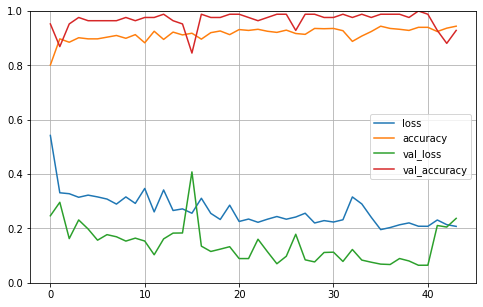

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [21]:
import tensorflow as tf

lstm = tf.keras.models.load_model("model.h5")

In [22]:
res = lstm.predict(x_test)

In [24]:
actions = np.array(['neutral', 'drowsy', 'sleep'])

In [25]:
for idx in range(8):
  print(actions[np.argmax(y_test[idx])], actions[np.argmax(res[idx])])

neutral neutral
sleep sleep
sleep sleep
neutral neutral
drowsy drowsy
drowsy neutral
drowsy drowsy
drowsy drowsy


In [26]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
yhat = lstm.predict(x_test)

ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [27]:
accuracy_score(ytrue, yhat)

0.9880952380952381

In [28]:
import tensorflow as tf

model =tf.keras.models.load_model("model.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpbxxwc0rc/assets


1112896